In [1046]:

source('../gitProjectExtras/gitBasedProjects/R/sourceAllLibs.r')
sourceAllLibs('../gitProjectExtras/gitBasedProjects/R/', trace = FALSE)
sourceAllLibs('../rasterextrafuns/rasterPlotFunctions/R/', trace = FALSE)
sourceAllLibs('../rasterextrafuns/rasterExtras/R/', trace = FALSE)

library(raster)
#library(rasterExtras)
library(fields)
sourceAllLibs("libs/", trace = FALSE)
graphics.off()

vars = c("fpc", "height", "evergreen")

xlims = list(c(0, 1), c(0, 120), c(0, 1))
transs  = list(logit, logN, logit)
itranss = list(logistic, exp, logistic)
ptranss = list(blankFun, function(x) 1-exp(-x*0.1), blankFun)
pitranss = list(blankFun, function(x) -10*log(1-x), blankFun)

ForestCentres = list(CNRM   = list(c(-70, -0), c(-53, -08), c(-60, -10), c(-67, -14)),
                     FGOALs = list(c(-70, -0), c(-55, -08), c(-60, -10), c(-67, -14)),
                     HADGEM = list(c(-70, -0), c(-52, -07), c(-67, -10)),
                     MIROC  = list(c(-75, -2), c(-51, -06), c(-61, -08), c(-66, -13)),
                     ENS    = list(c(-72, -1), c(-54, -09), c(-61, -09), c(-66, -14)))

In [71]:
dir = 'outputs/'
models = list.files(dir)
model = models[1]
ForestCentre = ForestCentres[[1]]

In [72]:
experiments = list.files(paste0(dir, model, '/'))
experiment = experiments[1]
list.files(paste(dir, model, experiment, '', sep = '/'))

[1] "evergreen.nc" "fpc.nc"       "gdd.nc"       "height.nc"    "temperate.nc"
[6] "tropical.nc"

In [77]:
dats = suppressWarnings(lapply(vars, function(i) raster(paste0(dir, '/', model, '/', experiment, '/', i, '.nc'))))

findBioclimPnts <- function(dat) {
    findPnt <- function(pnt)  
        dat[cellFromXY(dat, pnt)]
    
    sapply(ForestCentre, findPnt)    
}                              
centres = lapply(dats, findBioclimPnts)
centres

    

[[1]]
                                        
0.9999883 0.9876459 0.9976255 0.9999967 

[[2]]
                                    
92.52792 11.84179 10.85633 19.12004 

[[3]]
                                        
0.9999857 0.9999549 0.9999685 0.9999803

Find centroid

[1]  8.409040  3.201611 10.071274

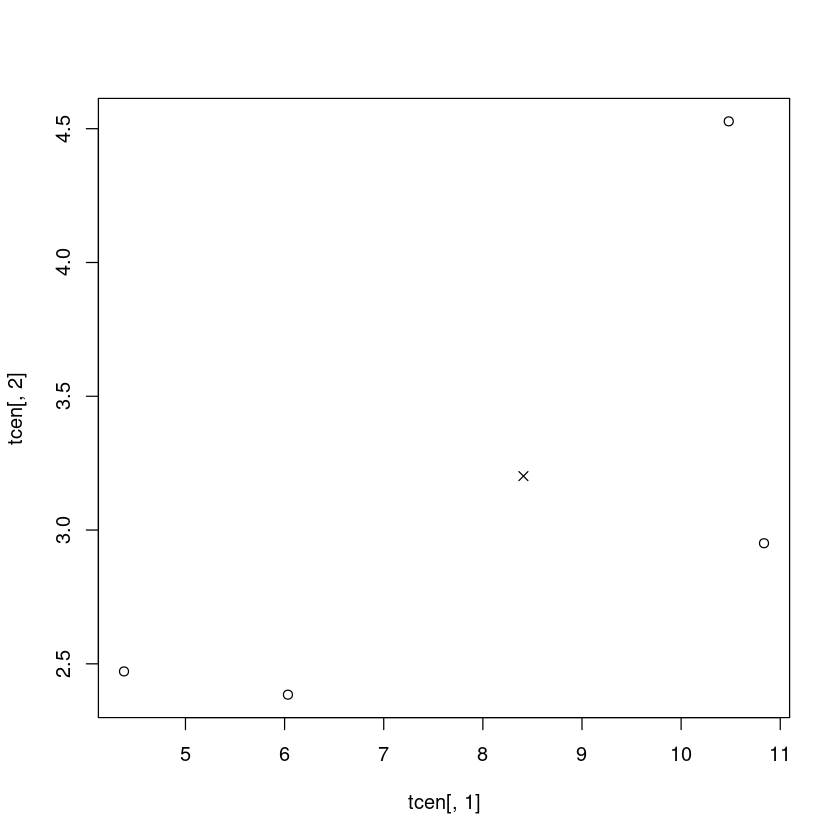

In [150]:
tcen = mapply(function(F,...) F(...), transs, centres)
              
## find centre
cencen = apply(tcen, 2, function(x) sqrt(mean(x^2)))
cencen
               
               
plot(tcen[,1], tcen[,2])
points(cencen[1] , cencen[2] , pch = 4)


In [725]:
continent_range = lapply(dats, function(r) range(r[], na.rm = TRUE))
continent_range = mapply(function(i,j) i(j), transs, continent_range)



-10.57196,-10.32683,-10.88799
11.00024,14.23327,10.99667


In [1007]:
clim = mapply(function(i,j) i(j), transs, dats)
clim = layer.apply(clim, function(i) i)[]
continent_range = unique(clim)
continent_range = continent_range[-1,]
                   
#continent_range                

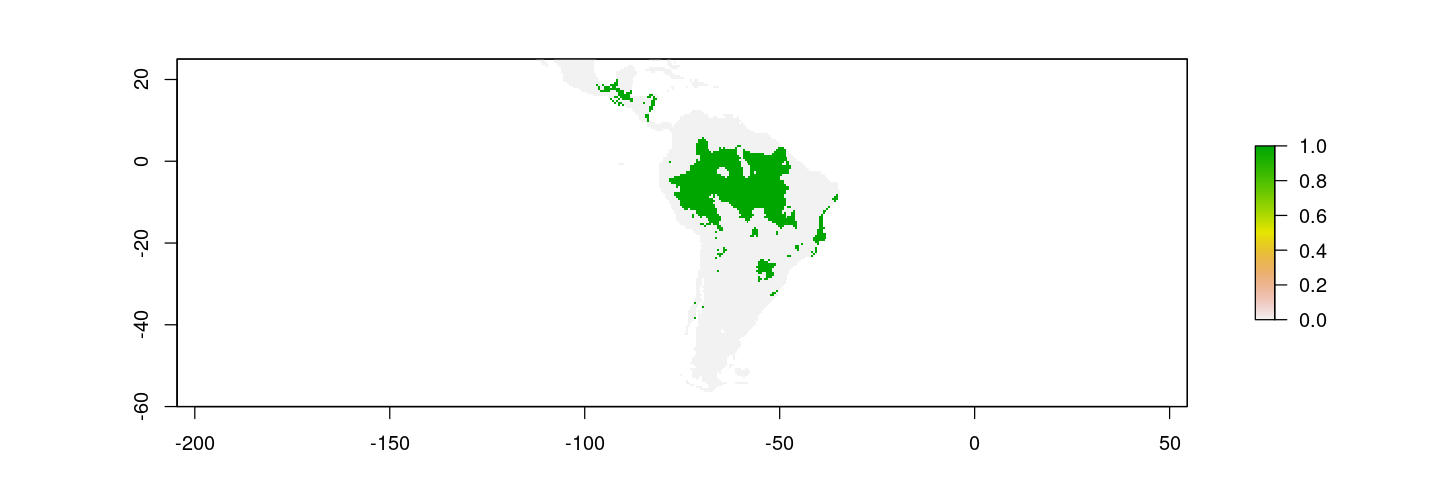

In [1022]:
randomBCrange <- function(i, inRange = TRUE, id = NULL) {
    if (inRange) {
        continent_range = tcen
        #bcrange = range(logistic(tcen[,i]))
        #bcrange = c(runif(1, 0, bcrange[1]), runif(1, bcrange[2], 1))
        #bcrange = logit(bcrange)
        #mu = logistic(mean(tcen[,i]))  
        #sd = runif(1, 0, 1)
        #bcrange = logit(mu) + c(-1, 1) * logit(sd)
    } #else {
        #bcrangei = logistic(continent_range[,i])
        if (is.null(id))
            mu = sample(continent_range[,i], 1)#runif(1, bcrangei[1], bcrangei[2])
        else
            mu = continent_range[id, i]
        #print(mu)
        #mu = logistic(mu)
        sd = runif(1, 0, 1)
        bcrange = mu + c(-1, 1) * logit(sd)
        bcrange = sort(bcrange)
        #crangei = logistic(continent_range[,i])
        #bcrange = c(1, 0)
        #while (bcrange[1] >= bcrange[2])
        #    bcrange = c(runif(1, 0, bcrangei[2]), runif(1, bcrangei[1], 1))
    #}
    
    
    bcrange
}
#id = sample(1:nrow(continent_range), 1)
selectPossibleNiche <- function() {
    dis = 2 
    id = sample(1:4, 1)
    while( max(dis) > 1) {
        bcranges = lapply(1:3, randomBCrange, id = id)
        dis = testWhereInSphere(bcranges, dats = matrix2list(tcen), list(blankFun))
        dis = apply(dis, 1, function(i) sqrt(sum(i^2)))
    }
    return(bcranges)
}
bcranges = selectPossibleNiche()

shift = sapply(bcranges, mean)
scale = sapply(bcranges, diff)/2

siftScar <- function(sh, sc, dat, trans)
    ((trans(dat)) - sh)/sc
sdats = mapply(siftScar, shift, scale, dats, transs)

out = sqrt(sum(layer.apply(sdats, function(i) i^2)))<1


In [1023]:
testWhereInSphere <- function(bcranges, dats, transs) {
    #print(bcranges)
    shift = sapply(bcranges, mean)
    scale = sapply(bcranges, diff)/2
    
    siftScar <- function(sh, sc, dat, trans)
        ((trans(dat)) - sh)/sc
    sdats = mapply(siftScar, shift, scale, dats, transs)
    
    if (!is.raster(dats[[1]])) return(sdats)
    out = sqrt(sum(layer.apply(sdats, function(i) i^2)))<1
    out[out == 0] = NaN
    return(out)                              
}

out = testWhereInSphere(bcranges, dats, transs)

                               

In [1033]:
testNiche <- function(bcranges, ForestCentre, ...) {
    inSphere = testWhereInSphere(bcranges, ...)
    if (is.na(mean(inSphere[], na.rm = TRUE))) {
        print("broke")
        return(c(0))
    }
    pol = rasterToPolygons(inSphere, digits = 2, dissolve = TRUE)

     
    ps = lapply(pol@polygons , slot , "Polygons")[[1]]
    coords = lapply(ps, function(x) slot(x, "coords"))

    findPntInPol <- function(pnt){
        for (i in 1:length(coords)) {
            test = point.in.polygon(pnt[1], pnt[2], coords[[i]][,1], coords[[i]][,2])
            if (test) break
        }
        if (test) return(i) else return(NaN)
    }
    
    Cpols = sapply(ForestCentre, findPntInPol)
    if (all(is.na(Cpols))) out = 1 else if (any(is.na(Cpols)))  out = 2 else if (var(Cpols) > 0) out = 3 else out = 4
    #if (any(is.na(Cpols)) || var(Cpols) > 0) return(FALSE) else return(TRUE)
    return(c(out))
}  

#bcranges
#testNiche(bcranges, ForestCentre, dats, transs)

In [1053]:
grab_cache = TRUE
testRandomNiche <- function(ntest) {
    tfile = paste0("temp/randomNicheTest--", ntest, ".Rd")
    if (file.exists(tfile) && grab_cache) 
        load(tfile)
    else {
        #id = sample(1:nrow(continent_range), 1)
        bcranges = selectPossibleNiche()#lapply(1:3, randomBCrange, id = id)
        test = testNiche(bcranges, ForestCentre, dats, transs)
        save(bcranges, test, file = tfile)
    }
    return(list(bcranges, test))
}
out = lapply(1:300, testRandomNiche)
for (i in out) cat(i[[2]][[1]], ',')
#fails = out[sapply(out, function(i) i[[2]] == 0)]
#length(fails)
#out[[1]]

4 ,4 ,4 ,4 ,3 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,3 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,3 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,3 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,3 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,3 ,4 ,4 ,3 ,4 ,4 ,3 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,3 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,3 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,3 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,3 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,3 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,3 ,4 ,4 ,3 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,3 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,

In [1054]:
addAxis <- function(i, side) {
    at = seq(0, 1, length.out = 11)
    labels = signif(pitranss[[i]](at), 1)
    at = ptranss[[i]](labels)
    axis(side, at = at, labels = labels)
}

[1] 16
[1] 16
[1] 16


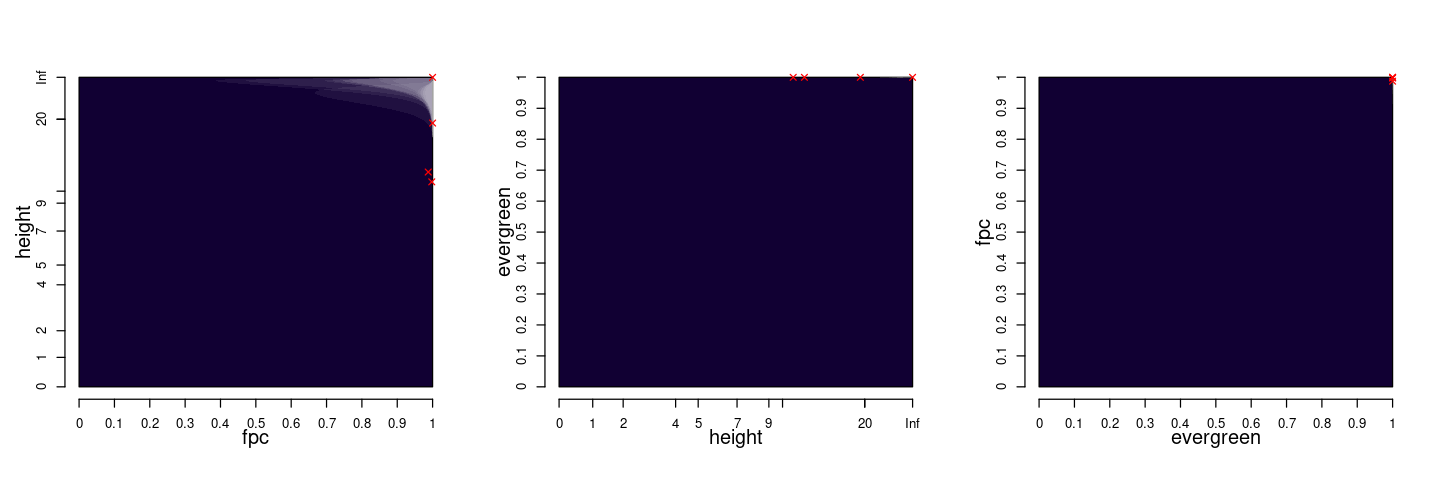

In [1055]:
x = seq(-1, 1, 0.001)
y = sqrt(1-x^2)
x = c(x, rev(x)); y = c(y, -rev(y))

plotNichProb <- function(i, j) {
    xc = ptranss[[i]](centres[[i]]); yc = ptranss[[j]](centres[[j]])
    plot(xc, yc, xlim = c(0,1), ylim = c(0,1), type = 'n', axes = FALSE, xlab = '', ylab = '')
    addAxis(i, 1)
    addAxis(j, 2)
    mtext(vars[i], side = 1, line = 2)
    mtext(vars[j], side = 2, line = 2)
    polygon(c(0, 1, 1, 0), c(0, 0, 1, 1), col = '#110033')
    

    addPoly <- function(fail, col, nc) {
        info = fail[[1]]

        shiftScale <- function(x, i){
            #x = logit(x)
            x = (x*diff(info[[i]])/2 + mean(info[[i]]))
            x = logistic(x)
        }
        xt = shiftScale(x, i); yt = shiftScale(y, j)
        polygon(xt, yt, col = make.transparent(col, 1-1/nc), border = NA)
    }
    addPolys <- function(id, col) {
        con = out[sapply(out, function(i) i[[2]] == id)]
        print(length(con))                 
        lapply(con, addPoly, col, length(con))
    }
    #addPolys(0, 'white')#'#110033')
    #addPolys(2, '#FF0000')
    addPolys(3, 'white')
    points(xc, yc, pch = 4, col = 'red')
}
options(repr.plot.width=12, repr.plot.height=4)
par(mfrow = c(1, 3))
nn = plotNichProb(1, 2)
nn = plotNichProb(2, 3)
nn = plotNichProb(3, 1)

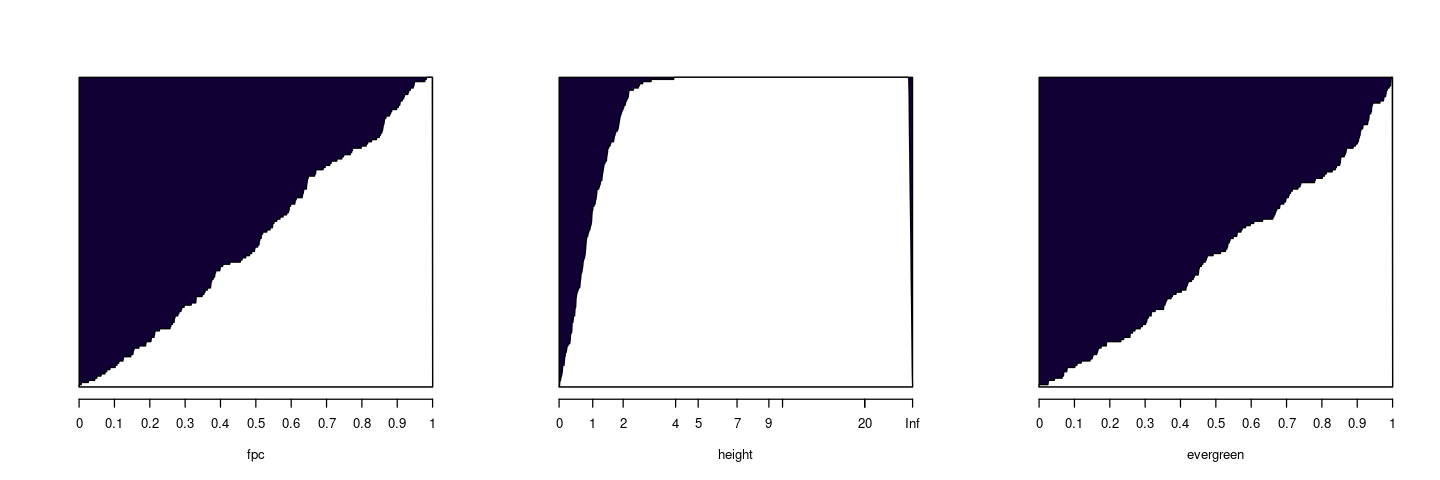

In [554]:
par(mfrow = c(1, 3))
detail = 3
det = 10^detail
x = seq(0, 1, 1/det)
y = rep(0, length(x))

varHist <- function(i) {
    for (fail in fails) {
        fail = fail[[1]][[i]]
        fail = det*round(logistic(fail), 3)
        y[fail[1]:fail[2]] =y[fail[1]:fail[2]] +1
    }
    plot(x, y, type = 'n', xlab = vars[i], ylab = '', axes = FALSE)
    polygon(c(0, 1, 1, 0), c(0, 0, max(y), max(y)), col = '#110033')
    polygon(c(0, x, 1), c(0, y, 0), col = 'white')
    addAxis(i, 1)
}
nn = lapply(1:3, varHist)

[[1]]
[1] -0.7869293  0.7524204

[[2]]
[1] -1.241023  0.441782

[[3]]
[1] -1.365790  2.270845

[1] -0.01725446 -0.39962040  0.45252771

[1] 0.7696749 0.8414024 1.8183177

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

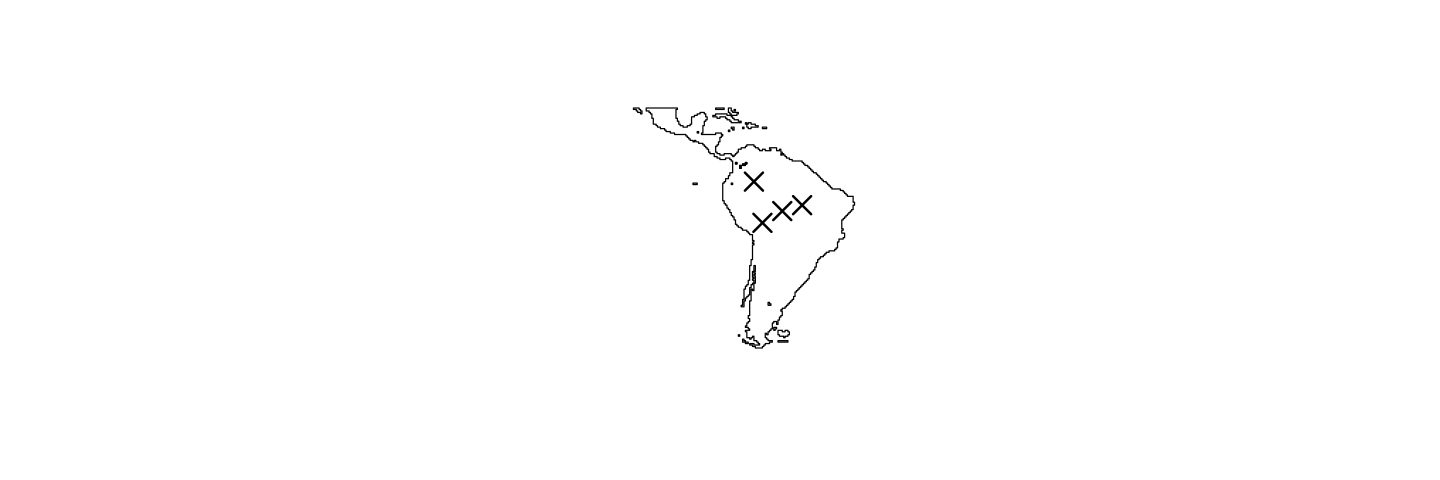

In [555]:
bcranges
shift = sapply(bcranges, mean)
scale = sapply(bcranges, diff)/2
shift
scale
siftScar <- function(sh, sc, dat, trans)
    (trans(dat) - sh)/sc
sdats = mapply(siftScar, shift, scale, dats, transs)

inCircle = sqrt(sum(layer.apply(sdats, function(i) i^2)))<1
pol = rasterToPolygons(inCircle, digits = 2, dissolve = TRUE)

plot(pol)
lapply(ForestCentre, function(i) points(i[1], i[2], pch = 4, lwd = 2, cex = 2))
       
ps = lapply(pol@polygons , slot , "Polygons")[[1]]
coords = lapply(ps, function(x) slot(x, "coords"))

findPntInPol <- function(pnt){
    for (i in 1:length(coords)) {
        test = point.in.polygon(pnt[1], pnt[2], coords[[i]][,1], coords[[i]][,2])
        if (test) break
    }
    if (test) return(i) else return(NaN)
}  
Cpols = sapply(ForestCentre, findPntInPol)
#if (any(is.na(Cpols)) || var(Cpol) > 0) 

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[1] NaN NaN NaN NaN

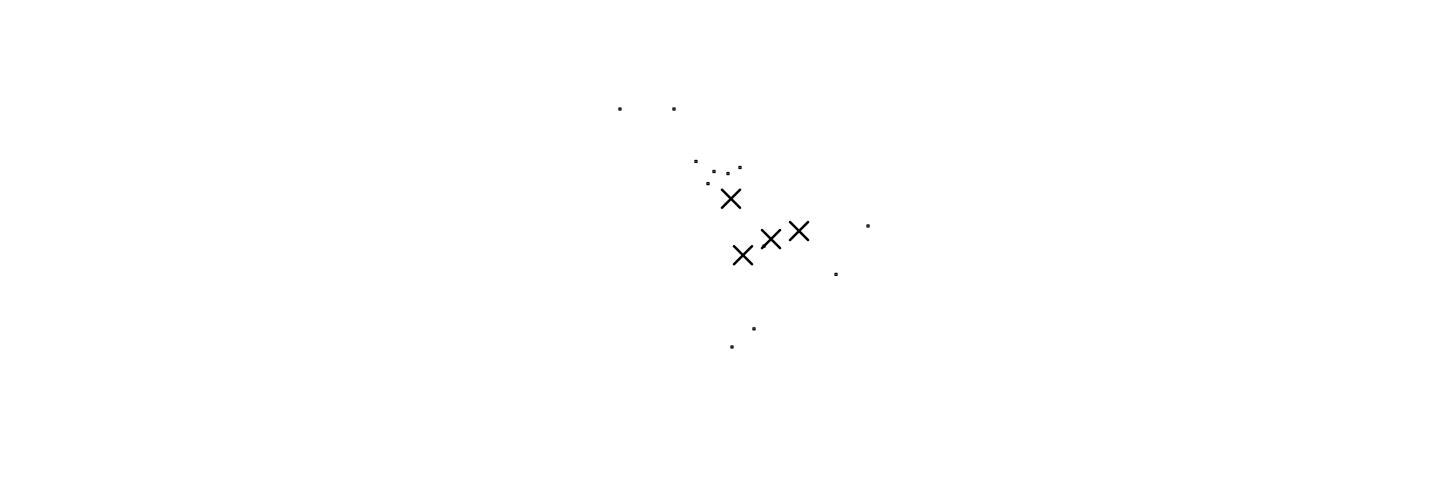

In [556]:
i = 1
dat = transs[[1]](dats[[1]])
minD = min(tcen[,i]); maxD = max(tcen[,i])
env = (dat > bcrange[1]) & (dat < bcrange[2])
env[env == 0] = NaN
#plot(env)
pol = rasterToPolygons(env, digits = 2, dissolve = TRUE)
plot(pol)
lapply(ForestCentre, function(i) points(i[1], i[2], pch = 4, lwd = 2, cex = 2))
       
ps = lapply(pol@polygons , slot , "Polygons")[[1]]
coords = lapply(ps, function(x) slot(x, "coords"))

findPntInPol <- function(pnt){
    for (i in 1:length(coords)) {
        test = point.in.polygon(pnt[1], pnt[2], coords[[i]][,1], coords[[i]][,2])
        if (test) break
    }
    if (test) return(i) else return(NaN)
}  
Cpols = sapply(ForestCentre, findPntInPol)
Cpols

In [267]:
#slot(pol, "polygons")[[1]]
#lapply(p[[1]], function(x) slot(x, "area"))
ps = lapply(pol@polygons , slot , "Polygons")[[1]]
coords = lapply(ps, function(x) slot(x, "coords"))

findPntInPol <- function(pnt){
    for (i in 1:length(coords)) {
        test = point.in.polygon(pnt[1], pnt[2], coords[[i]][,1], coords[[i]][,2])
        if (test) break
    }
    if (test) return(i) else return(NaN)
}  
Cpols = sapply(ForestCentre, findPntInPol)
Cpols         

[1] NaN NaN NaN NaN

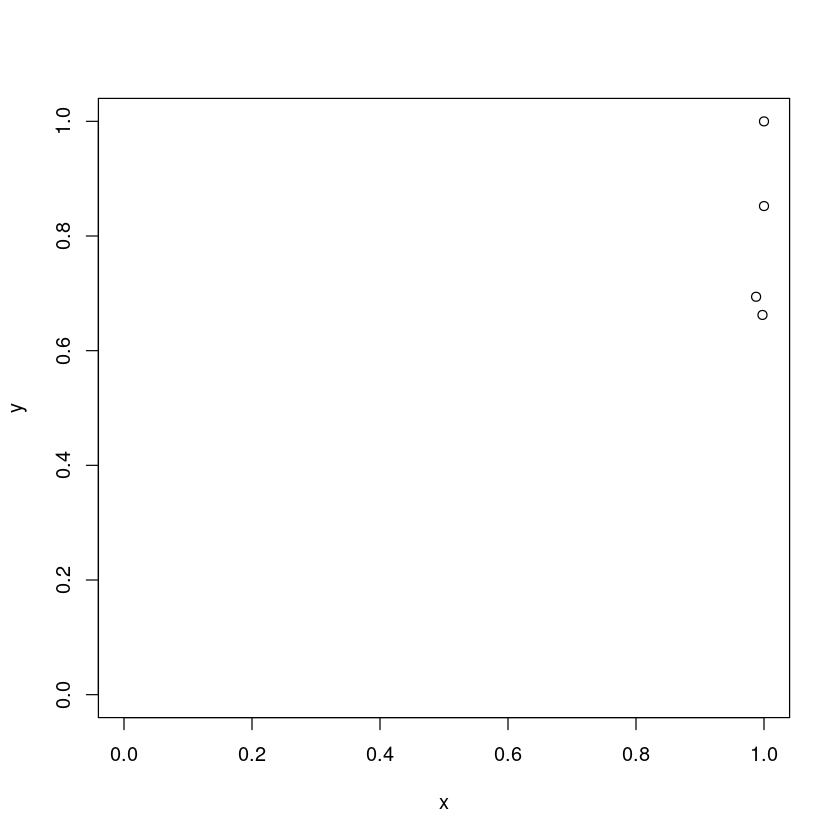

In [75]:

x = ptranss[[i]](centres[,i]); y = ptranss[[j]](centres[,j])
plot(x, y, xlim = c(0,1), ylim = c(0,1))

In [ ]:
dat = dats[[1]]
